In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("hipparcos_subset_100stars.csv")


Average measurements per star: 120.9
Range: 51 to 291 measurements


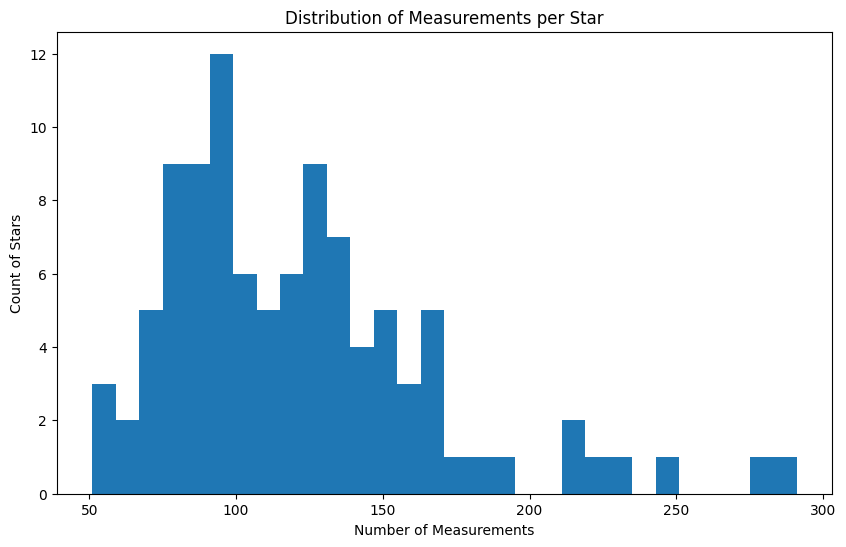

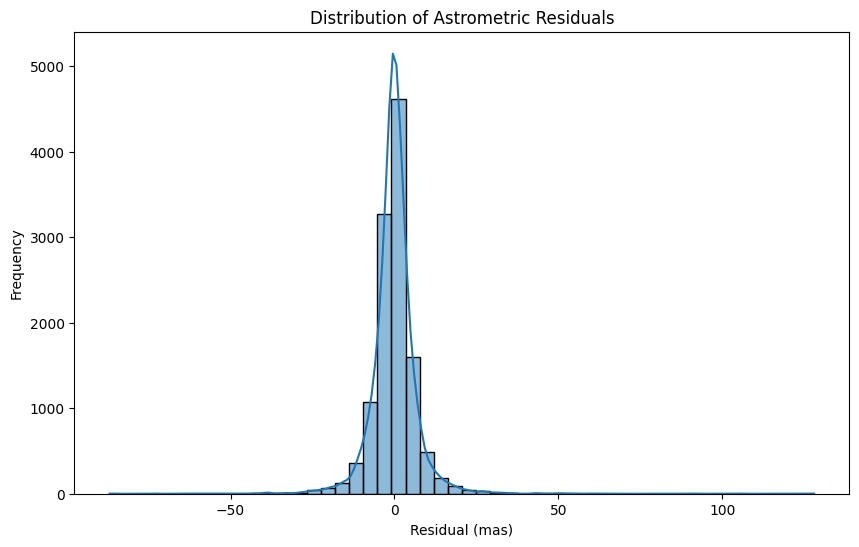

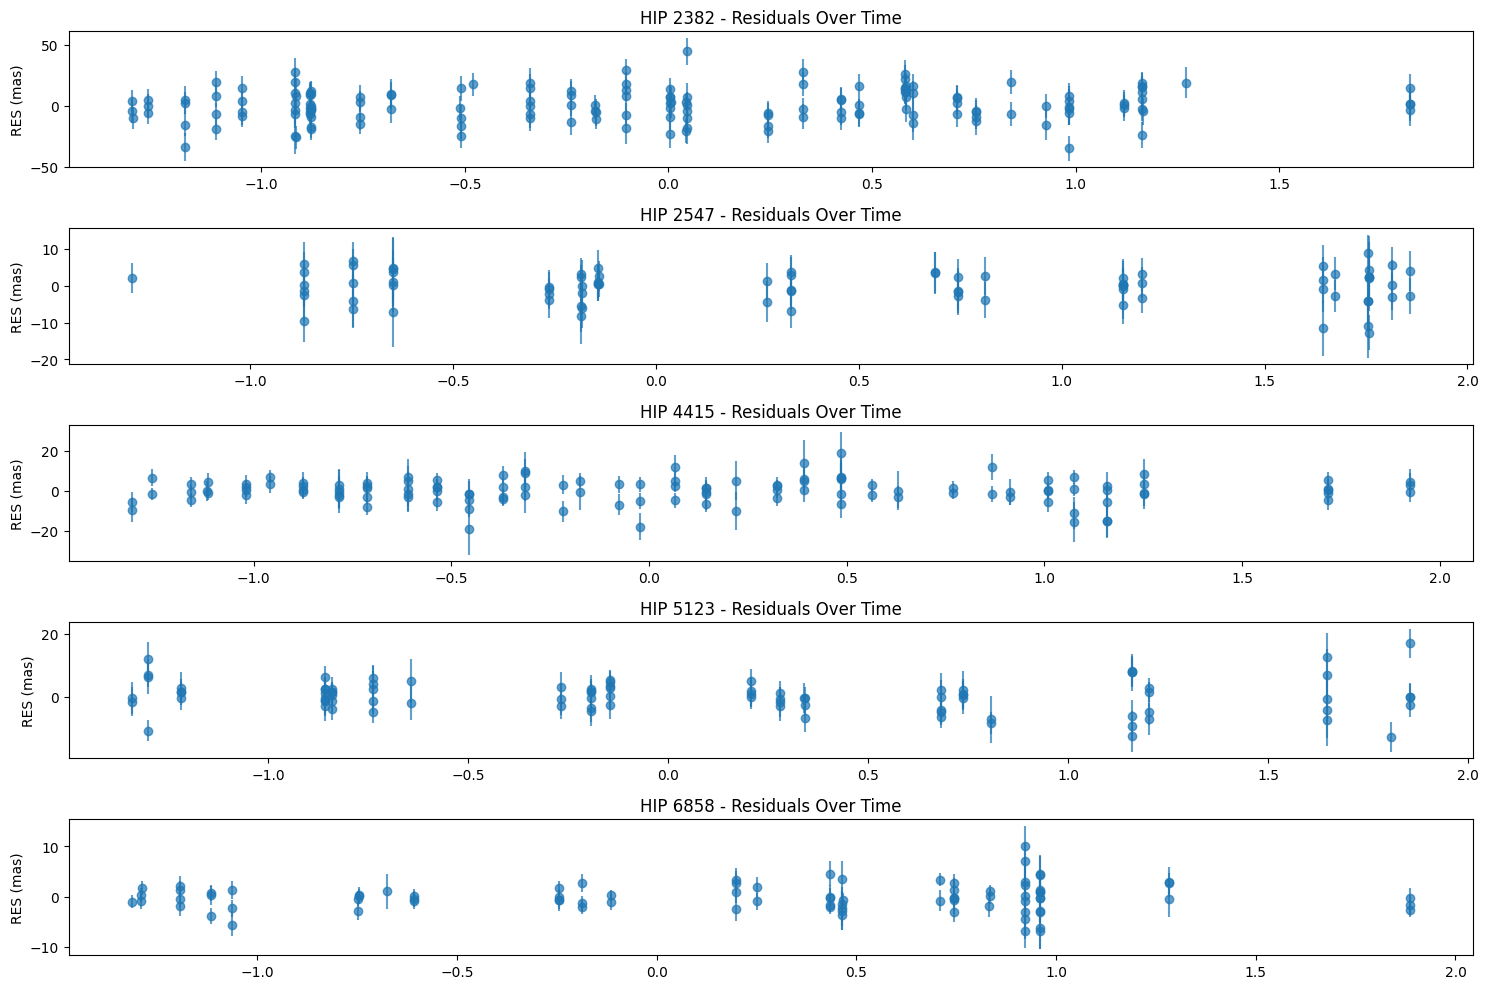

In [8]:
# Count measurements per star
star_counts = df.groupby('HIP').size()
print(f"Average measurements per star: {star_counts.mean():.1f}")
print(f"Range: {star_counts.min()} to {star_counts.max()} measurements")

# Plot histogram of measurements per star
plt.figure(figsize=(10, 6))
plt.hist(star_counts, bins=30)
plt.title('Distribution of Measurements per Star')
plt.xlabel('Number of Measurements')
plt.ylabel('Count of Stars')
plt.show()

# Examine residual distribution
df_valid = df[df['SRES'] > 0]  # Only valid measurements (SRES > 0)
plt.figure(figsize=(10, 6))
sns.histplot(df_valid['RES'], bins=50, kde=True)
plt.title('Distribution of Astrometric Residuals')
plt.xlabel('Residual (mas)')
plt.ylabel('Frequency')
plt.show()

# Time series analysis for a few example stars
example_stars = df['HIP'].unique()[:5]  # Take first 5 stars
plt.figure(figsize=(15, 10))

for i, hip in enumerate(example_stars):
    star_data = df[(df['HIP'] == hip) & (df['SRES'] > 0)]
    if len(star_data) < 10:
        continue
        
    plt.subplot(len(example_stars), 1, i+1)
    plt.errorbar(star_data['EPOCH'], star_data['RES'], 
                 yerr=star_data['SRES'], fmt='o', alpha=0.7)
    plt.title(f'HIP {hip} - Residuals Over Time')
    plt.ylabel('RES (mas)')
    
plt.tight_layout()
plt.show()


In [9]:
def create_features_for_modeling(df):
    """Create star-level features from time-series measurements"""
    features = []
    
    for hip, star_data in df.groupby('HIP'):
        # Use only valid measurements
        valid_data = star_data[star_data['SRES'] > 0]
        
        if len(valid_data) < 10:  # Skip stars with too few measurements
            continue
            
        # Star parameters (constant for each star)
        plx = valid_data['Plx'].iloc[0]
        pmRA = valid_data['pmRA'].iloc[0]
        pmDE = valid_data['pmDE'].iloc[0]
        
        # Time series features
        res_mean = valid_data['RES'].mean()
        res_std = valid_data['RES'].std()
        res_min = valid_data['RES'].min()
        res_max = valid_data['RES'].max()
        res_range = res_max - res_min
        
        # Count measurements
        n_measurements = len(valid_data)
        
        feature_dict = {
            'HIP': hip,
            'Plx': plx,
            'pmRA': pmRA, 
            'pmDE': pmDE,
            'res_mean': res_mean,
            'res_std': res_std,
            'res_range': res_range,
            'n_measurements': n_measurements
        }
        
        features.append(feature_dict)
    
    return pd.DataFrame(features)

# Create features dataframe
features_df = create_features_for_modeling(df)
features_df.to_csv("hipparcos_star_features.csv", index=False)
print("Features saved to 'hipparcos_star_features.csv'")


Features saved to 'hipparcos_star_features.csv'


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Load features CSV file
features_df = pd.read_csv("hipparcos_star_features.csv")

# Simulate target variable for demonstration purposes (1=exoplanet, 0=no exoplanet)
np.random.seed(42)
features_df['has_exoplanet'] = np.random.binomial(1, 0.1, size=len(features_df))

# Prepare data for modeling
X = features_df.drop(['HIP', 'has_exoplanet'], axis=1)
y = features_df['has_exoplanet']

# Handle missing values and standardize features
X.fillna(X.mean(), inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} stars")
print(f"Test set: {X_test.shape[0]} stars")

# Initialize models and evaluate them
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # For Decision Tree and Random Forest, show feature importance if available
    if hasattr(model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        print("Top 5 important features:")
        print(importances.head(5))


Training set: 70 stars
Test set: 30 stars

=== Decision Tree ===
AUC: 0.537
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        27
           1       0.00      0.00      0.00         3

    accuracy                           0.87        30
   macro avg       0.45      0.48      0.46        30
weighted avg       0.81      0.87      0.84        30

Top 5 important features:
          feature  importance
0             Plx    0.389478
1            pmRA    0.325949
6  n_measurements    0.284573
2            pmDE    0.000000
3        res_mean    0.000000

=== Random Forest ===
AUC: 0.340
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        27
           1       0.00      0.00      0.00         3

    accuracy                           0.90        30
   macro avg       0.45      0.50      0.47        30
weighted avg       0.81      0.90      

/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

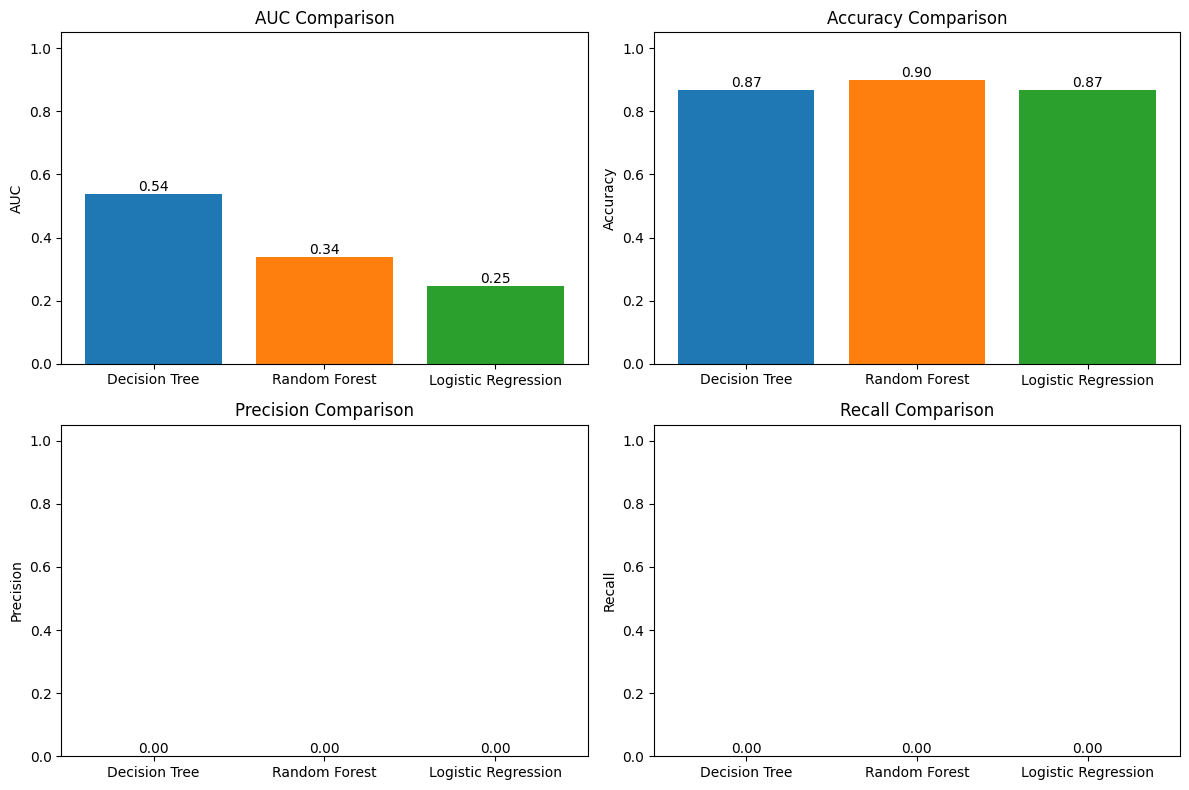

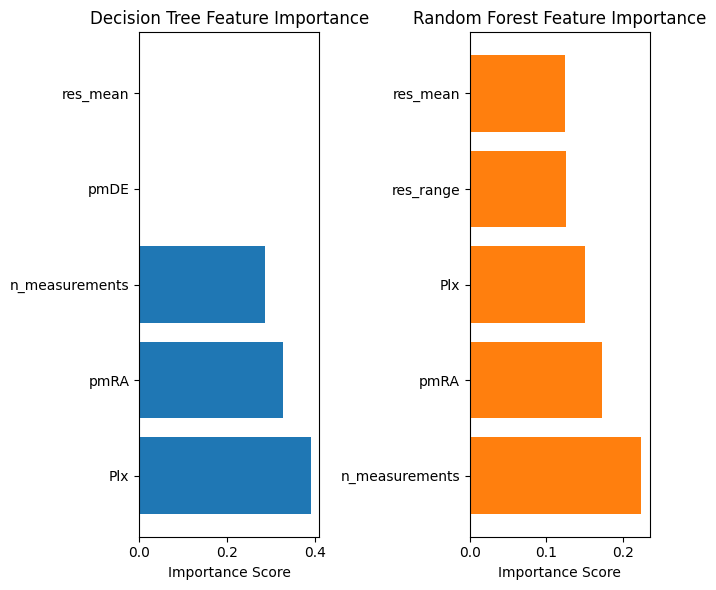

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load features CSV file
features_df = pd.read_csv("hipparcos_star_features.csv")

# Simulate target variable for demonstration purposes
np.random.seed(42)
features_df['has_exoplanet'] = np.random.binomial(1, 0.1, size=len(features_df))

# Prepare data for modeling
X = features_df.drop(['HIP', 'has_exoplanet'], axis=1)
y = features_df['has_exoplanet']

# Handle missing values and standardize features
X.fillna(X.mean(), inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Store metrics for visualization
metrics = {
    'Model': [],
    'AUC': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': []
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics['Model'].append(name)
    metrics['AUC'].append(roc_auc_score(y_test, y_prob))
    metrics['Accuracy'].append(report['accuracy'])
    metrics['Precision'].append(report['1']['precision'])
    metrics['Recall'].append(report['1']['recall'])

# Convert to DataFrame for plotting
results_df = pd.DataFrame(metrics)

# Plotting
plt.figure(figsize=(12, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create subplots
for i, metric in enumerate(['AUC', 'Accuracy', 'Precision', 'Recall']):
    plt.subplot(2, 2, i+1)
    bars = plt.bar(results_df['Model'], results_df[metric], color=colors)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim(0, 1.05)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
for i, (name, model) in enumerate(models.items()):
    if hasattr(model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(5)
        
        plt.subplot(1, 3, i+1)
        plt.barh(importances['feature'], importances['importance'], color=colors[i])
        plt.title(f'{name} Feature Importance')
        plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()
